In [2]:
import pandas as pd
import numpy as np
from sympy import *
import math
import spiceypy as sp
import astropy.coordinates
import re
import sgp4.api as sg
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import os
import sys
from timeit import default_timer as timer
from astropy.time import Time
from astropy.time import TimeDelta
import datetime as dt
import timeit
import skyfield
# from skyfield.framelib import ecliptic_frame # For rotation matrices
from skyfield.api import EarthSatellite # For time calculations
from skyfield.api import load
from skyfield.api import N,S,E,W, wgs84
from skyfield.positionlib import Barycentric
from numba import jit

In [3]:
path = "/data/survey_simulator/v2.99_detections/"
dir_list = os.listdir(path)

dflist=[]

dflist.append(pd.read_hdf(path+'/visit-0000000.h5'))
dflist.append(pd.read_hdf(path+'/visit-0010000.h5'))

dfin=pd.concat(dflist)

dfin.sort_values(['FieldID'], inplace=True)

dfin.groupby(['FieldID']).count()['ObjID']

names=dfin['ObjID'].values


with open('/data/projects/lsst/satellites/starlink_v2_tle_final.txt') as f:
    starlinks = f.read().splitlines() 
    
chunks = [starlinks[n:n + 3] for n in range(0, len(starlinks), 3)]
satdf=pd.DataFrame(chunks,columns=["SatID",'TLELine1',"TLELine2"])
satdf['SatNumber']=satdf.index


In [4]:
def getObserverStates(observationTimes,observerLatitudeDeg=0,observerLatitudeDirection='N',
                     observerLongitudeDeg=0,observerLongitudeDirection='W',observerElevationMeters=0):
    """Produce observer state vectors at observation times.
    Parameters
    ----------
    observationTimes
        Astropy Time array
    observerLatitudeDeg
        observer WGS84 latitude in degrees (float)
    observerLatitudeDirection
        observer latitude direciton ('N' for North or 'S' for South)
    observerLongitudeDeg
        observer WGS84 longitude in degrees (float)
    observerLatitudeDirection
        observer longitude direciton ('E' for East or 'W' for West)
    observerElevationMeters
        observer elevation in meters
    Returns
    -------
    observer positions
        WGS84 x,y,z observer positions at observation epochs in kilometers.
    observer velocities
        WGS84 dx/dt, dy/dt, dz/dt observer velocity at observation epochs in kilometers per second.
    """
    # load time scale object from skyfield
    ts = load.timescale()
    times = ts.from_astropy(observationTimes)
    if(observerLatitudeDirection == 'S'):
        latDir = S
    elif (observerLatitudeDirection == 'N'):
        latDir = N
    else:
        Error("Observer Latitude Direction unknown. Must be 'N' or 'S'.")
    if(observerLongitudeDirection == 'W'):
        lonDir = W
    elif (observerLongitudeDirection == 'E'):
        lonDir = E
    else:
        Error("Observer Longitude Direction unknown. Must be 'E' or 'W'.")
    observer = wgs84.latlon(observerLatitudeDeg * latDir, observerLongitudeDeg * lonDir, elevation_m=observerElevationMeters)
    observerAt = observer.at(times)
    return np.hstack([observerAt.position.km.T])

In [5]:
def getSatelliteStates(times,TLEFirstLine,TLESecondLine):
    """Produce satellite state vectors at observation times.
    Parameters
    ----------
    times
        Astropy Time array
    TLEFirstLine
        First Line of TLEs (str)
    TLESecondLine
        Second Line of TLEs (str)
    Returns
    -------
    satPositions
        x,y,z satellite geocentric positions in kilometers according to SGP4 propagation
    satVelocities
        dx/dt, dy/dt, dz/dt satellite geocentric velocities in kilometers/second according to SGP4 propagation
    """
    satPositions=[]
    satVelocities=[]
    r=0
    v=0
    e=0
    
    sat = sg.Satrec.twoline2rv(TLEFirstLine, TLESecondLine)  
    
    if(np.size(times)>1):
        for jd_t in times.jd:
#             print(jd_t)
            # convert MJD to JD for sgp4 propagation calculation
            fr, whole = math.modf(float(str(jd_t)))  # fr = digits after decimal of MJD

            e, r, v = sat.sgp4(float(str(jd_t)), round(fr, 10))  # r is [x,y,z] for propagated satellite

            satPositions.append(r)
            satVelocities.append(v)
#             print(r)
        return np.array(satPositions), np.array(satVelocities)
    else:
        fr, whole = math.modf(float(str(times.jd)))  # fr = digits after decimal of MJD
        e, r, v = sat.sgp4(float(str(times.jd)), round(fr, 10))  # r is [x,y,z] for propagated satellite
        return r,v

In [6]:
def radec2icrf(ra, dec, deg=True):
    """Convert Right Ascension and Declination to ICRF xyz unit vector.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    deg ... True: angles in degrees, False: angles in radians
    Returns:
    --------
    x,y,z ... 3D vector of unit length (ICRF)
    """
    deg2rad=np.deg2rad
    array=np.array
    cos=np.cos
    sin=np.sin
    
    if(deg):
        a = deg2rad(ra)
        d = deg2rad(dec)
    else:
        a = array(ra)
        d = array(dec)
    
    cosd = cos(d)
    x = cosd*cos(a)
    y = cosd*sin(a)
    z = sin(d)
    
    return array([x, y, z])

In [7]:
def icrf2radec(pos, deg=True):
    """Convert ICRF xyz to Right Ascension and Declination.
    Geometric states on unit sphere, no light travel time/aberration correction.
    
    Parameters:
    -----------
    pos ... real, dim=[n, 3], 3D vector of unit length (ICRF)
    deg ... True: angles in degrees, False: angles in radians
    Returns:
    --------
    ra ... Right Ascension [deg]
    dec ... Declination [deg]
    """
    norm=np.linalg.norm
    array=np.array
    arctan2=np.arctan2
    arcsin=np.arcsin
    rad2deg=np.rad2deg
    modulo=np.mod
    pix2=2.*np.pi
    
    if(pos.ndim>1):
        r=norm(pos,axis=1)
        xu=pos[:,0]/r
        yu=pos[:,1]/r
        zu=pos[:,2]/r
    else:
        r=norm(pos)
        xu=pos[0]/r
        yu=pos[1]/r
        zu=pos[2]/r
    
    phi=arctan2(yu,xu)
    delta=arcsin(zu)
    
    if(deg):
        ra = modulo(rad2deg(phi)+360,360)
        dec = rad2deg(delta)
    else:
        ra = modulo(phi+pix2,pix2)
        dec = delta
    
    return ra, dec

In [81]:
def phaseFunction(phase_angle):
#diffusely illuminated cylinder phase function (Johnson et al, Krag)
    return (1/(4*pi))*(((pi - phase_angle)*cos(phase_angle))+sin(phase_angle))
# diffusely illuminated sphere phase function (Krag)
      #return (2/(3*pi**2))*(((pi - phase_angle)*cos(phase_angle))+sin(phase_angle))

In [84]:
def brightness(sunVec, satVec, distance, sat_r):
    au = 149597870.7
    phase_angle = acos((np.dot(sunVec,satVec))/(np.linalg.norm(sunVec) * np.linalg.norm(satVec)))
    Msun = -26.74
    
# diffuse albedo's from provided paper (Johnson et al. (2021)) the hard coded numbers can all be changed to variables in the future to take in satellite specifics
    #if (phase_angle <= (pi/2)):
    appMag = Msun - (2.5*math.log10((1/pi)*((0.9 * abs(cos(phase_angle)))/(np.linalg.norm(sat_r) - 6371)**2))) - (2.5*math.log10(((0.7*0.21*phaseFunction(phase_angle))/(np.linalg.norm(sat_r) - 6371)**2)))
   # if (phase_angle > (pi/2)):
       # appMag = Msun - (2.5*math.log10((1/pi)*((2.1*0.1*0.7)/distance**2))) - (2.5*math.log10((1/pi)*((0.7*0.21*phaseFunction(phase_angle))/distance**2)))
# Understanding photometeric phase angle corrections
#     appMag = Msun - 2.5*math.log10(((pi*2.1**2)/(4*distance**2)) * 0.14 * phaseFunction(phase_angle))
#Hejduk paper calculation
#     appMag = -26.74 - (2.5*math.log10(0.7*0.21*(0.17*phaseFunction(phase_angle) + 0.83/(4*pi)))) + (5*math.log10(distance))

#normalize distance to 1000 km
#Analytical simulations of the effect of satellite constellations Bassa et al. (2021)
    #appMag = Msun + (2.5*math.log10(distance**2)) - (2.5*math.log10(0.25)) + ((0.12*distance)/(np.linalg.norm(sat_r) - 6371))
    #Johnson
    normMag = appMag - 5*math.log10(distance/1000) #- ((0.12*distance)/(np.linalg.norm(sat_r) - 6371))#5*math.log10(np.linalg.norm(sunVec)/au)
    

    return np.array([normMag, phase_angle*180/np.pi])
    

Average Normalized Magnitude:  8.637384471887216
Standard deviation:  1.2729894585879213


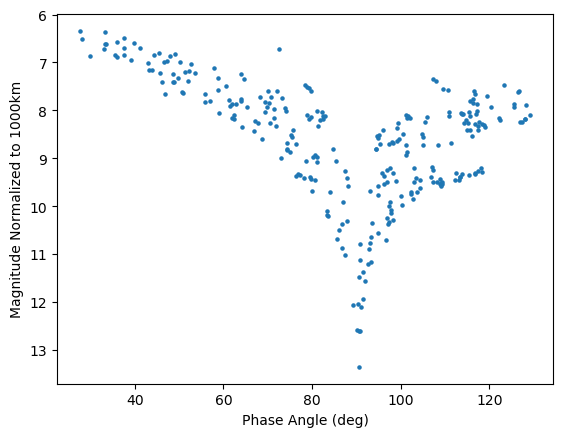

In [85]:
field_ids = dfin['FieldID'].unique()
FOV_dist_lim = 3/180*np.pi #3 degrees distance to FOV for a satellite to be excluded
rearth = 6371
pa1 = []
am1 = []
bf1 = []
count = 0
#field_ids[::1000]:
for f in range(1,5):
    #take in data to calculate sun vectors and time in J2000
    data = dfin[dfin['FieldID']==f]
    sun_vector = data[['Obs-Sun(J2000x)(km)', 'Obs-Sun(J2000y)(km)', 'Obs-Sun(J2000z)(km)']][0:1].values[0]
    sv = sun_vector/np.linalg.norm(sun_vector)
    ra_f  = data['AstRA(deg)']  # RA for all objects
    dec_f = data['AstDec(deg)']  # Dec for all objects
    range_f = data['AstRange(km)'] # Distance for all objects
    time_f = data['FieldMJD'].unique()[0]
   # objID_f = data['ObjID']
    xyzu = radec2icrf(ra_f, dec_f, deg=True)
    
    min_ra, max_ra = min(ra_f), max(ra_f) # Global minimum and maximums for objects in the field in question
    min_dec, max_dec = min(dec_f), max(dec_f)
    
    
    FOV_mean_direction=np.median(xyzu,axis=1)
    #print(FOV_mean_direction)
    time = Time(time_f, format='mjd')
    #at the time calculate the observer vector
    observer_state = getObserverStates(time,observerLatitudeDeg=30.24506,observerLatitudeDirection='S',
                  observerLongitudeDeg=70.74913,observerLongitudeDirection='W',observerElevationMeters=2663)
    for index, row in satdf.iterrows():
        #calculate the satellite vector
        sat_r,sat_v = getSatelliteStates(time,row['TLELine1'],row['TLELine2'])
        r_parallel = np.dot(sat_r,sv)*sv
        r_tangential = sat_r-r_parallel
        
        if(np.linalg.norm(r_tangential)<rearth):
            continue
        #obU = observer_state/np.linalg.norm(observer_state)
        #print(obU,FOV_mean_direction)
        #obtosatU = (sat_r - observer_state)/np.linalg.norm(sat_r - observer_state)
        #calculate if within 3 degrees FOV
        #angle between observer vector and satellite vector
        #would make sense to do between observer and observer to satellite but gives a zero answer
        ang_dist = np.arccos(np.dot(FOV_mean_direction,sat_r)/(np.linalg.norm(FOV_mean_direction) * np.linalg.norm(sat_r))) 
        #ang_dist = np.arccos(np.dot(FOV_mean_direction,sat_r)/sat_d)
        #possibly can be imporoved, can not figure out why getting zero when implementing the other ways
        
        x, y, z = sat_r[0], sat_r[1], sat_r[2] # Possible issue due to Keplerian to non-Keplerian elements
        length = np.sqrt(x**2 + y**2 + z**2)
        norm_coords = np.array([x/length, y/length, z/length])  # normalizing onto unit sphere
        ra, dec = icrf2radec(norm_coords)
        
        x1,y1,z1 = observer_state[0], observer_state[1], observer_state[2]
        length = np.sqrt(x1**2 + y1**2 + z1**2)
        norm_coords = np.array([x1/length, y1/length, z1/length])  # normalizing onto unit sphere
        ra1, dec1 = icrf2radec(norm_coords)
        
        #if(ang_dist > FOV_dist_lim):
        # if the object is in the field i.e. within 1 degree
        
        if  (abs(ra - ra1) >= 5): 
            continue
        if  (abs(dec - dec1) >= 5):
            continue
        #print ((ra - ra1))
        # sun to satellite
        sun_vector = sun_vector + (sat_r - observer_state) #possibly wrong assumes sun vector is sun to observer
        #distance inputted to function is the satellite magnitude minus observer magnitude which should give the satellites distance from the surface where the observer is
        #print (np.linalg.norm(sat_r) - 6371)
        pa1.append(brightness(sun_vector, sat_r - observer_state, np.linalg.norm(sat_r - observer_state), sat_r)[1])
        am1.append(brightness(sun_vector, sat_r - observer_state, np.linalg.norm(sat_r - observer_state), sat_r)[0])
        #distance inputted is the magnitude of the satellite vector minus the observer vector
        
        #effects of earthshine?

        
# plt.scatter(pa1,bf1, 5)
plt.scatter(pa1,am1, 5)
axis = plt.gca()
axis.set_ylim(axis.get_ylim()[::-1])
plt.xlabel('Phase Angle (deg)')
plt.ylabel('Magnitude Normalized to 1000km')
total = 0
for x in am1:
    total += x
print("Average Normalized Magnitude: ",  total/len(am1))
print("Standard deviation: ", np.std(am1))
# total = 0
# for x in bf1:
#     total += x
# print("Average Best Fit Normalized Magnitude", total/len(bf1))

#Goal averages from paper 6.9 +- 0.9 spanning Mv ~4-13